In [1]:
import networkx as nx
import itertools
import pandas as pd
import numpy as np
from stellargraph import StellarGraph
from rdkit.Chem import AllChem, DataStructs
import json
from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow import keras
import tensorflow as tf

import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import HinSAGELinkGenerator
from stellargraph.layer import HinSAGE, link_regression, link_classification
from tensorflow.keras import Model, optimizers, losses, metrics

import multiprocessing
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('float32')

2023-06-28 15:54:42.418577: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-28 15:54:48.782705: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
g = nx.read_graphml("./graph/test_graph.gml")
species_features_dummy = pd.read_csv("./data/species_features.csv.gz", index_col=0)
#species_features_dummy = pd.read_csv("./data/species_BaseNEncoder.csv.gz", index_col=0)
#species_features_dummy = pd.read_csv("./data/species_Multi_dim_scale.csv.gz", index_col=0)
molecule_features_dummy = pd.read_csv("./data/molecule_features.csv.gz", index_col=0).astype("int8")
df_agg = pd.read_csv("./data/lotus_agg_test.csv.gz", index_col=0)
#molecule_features_dummy = pd.read_csv("./data/molecule_features_dummy.csv.gz", index_col=0).astype('int8')

In [3]:
species_feat = species_features_dummy[species_features_dummy.index.isin(df_agg.organism_name)]
molecule_feat = molecule_features_dummy[molecule_features_dummy.index.isin(df_agg.structure_smiles_2D)]

In [4]:
g_train = nx.read_graphml("./graph/train_graph.gml")

In [5]:
g = nx.create_empty_copy(g)
g_merged = nx.compose(g_train, g)

In [6]:
#g = nx.create_empty_copy(g)
G = StellarGraph.from_networkx(g_merged,
                               node_features={'species': species_features_dummy,
                                              'molecule':molecule_features_dummy})

In [7]:
print(G.info())
G.check_graph_for_ml()

StellarDiGraph: Directed multigraph
 Nodes: 184990, Edges: 700916

 Node types:
  molecule: [148190]
    Features: float32 vector, length 27
    Edge types: molecule-present_in->species
  species: [36800]
    Features: float32 vector, length 70
    Edge types: species-has->molecule

 Edge types:
    species-has->molecule: [350458]
        Weights: all 1 (default)
        Features: none
    molecule-present_in->species: [350458]
        Weights: all 1 (default)
        Features: none


In [8]:
model = tf.keras.models.load_model("./model/batch_256_layer_256/", compile=True)

In [9]:
test = df_agg.sample(n=1000)

In [10]:
test = test[['structure_smiles_2D', 'organism_name']].to_numpy()

In [11]:
test_flow = HinSAGELinkGenerator(G,
                                 batch_size=256,
                                num_samples=[1,1],
                                head_node_types=["molecule", "species"]).flow(test, np.ones(len(test)).reshape(-1, 1))

In [12]:
test.shape

(1000, 2)

In [13]:
result = model.predict(test_flow).flatten()

4/4 [==============================] - 0s 12ms/step


In [14]:
sum(result>0.9)

282

(array([ 17.,  18.,  39.,  37.,  61.,  86., 106., 153., 192., 291.]),
 array([0.0033128 , 0.10252029, 0.20172779, 0.30093527, 0.40014279,
        0.49935028, 0.59855777, 0.69776523, 0.79697275, 0.89618021,
        0.99538773]),
 <BarContainer object of 10 artists>)

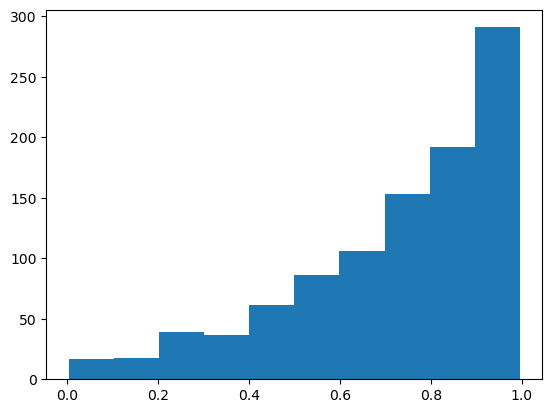

In [15]:
plt.hist(result)

In [16]:
try_test = np.array([['C=C(C)C1CCC2(C)CCC3(C)C(CCC4C5(C)CCC(O)C(C)(C)C5CCC43C)C12', 'Homo sapiens']])

In [17]:
test_flow = HinSAGELinkGenerator(G,
                                 batch_size=256,
                                num_samples=[1,1],
                                head_node_types=["molecule", "species"]).flow(try_test, np.ones(len(try_test)).reshape(-1, 1))

In [18]:
model.predict(test_flow)

1/1 [==============================] - 0s 33ms/step


array([[0.7118176]], dtype=float32)